In [54]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import joblib
import warnings

warnings.filterwarnings('ignore')

### 3.1 Data Preprocessing

In [55]:
# Load the data
energy_data = pd.read_csv("energydata_complete.csv")

# format dates
energy_data['date'] = pd.to_datetime(energy_data['date'], format="%Y-%m-%d %H:%M:%S")

#### 3.1.1 Feature Engineering

In [56]:
# Feature engineering
def second_day(x):
    return x.hour * 3600 + x.minute * 60 + x.second

def weekend_weekday(x):
    if x.weekday() >= 5:
        return 'Weekend'
    else:
        return 'Weekday'

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# Existing feature engineering
energy_data['NSM'] = energy_data['date'].apply(second_day)
energy_data['WeekStatus'] = energy_data['date'].apply(weekend_weekday)
energy_data['Day_of_week'] = energy_data['date'].dt.day_name()

# Additional feature engineering
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['Month'] = energy_data['date'].dt.month
energy_data['Day'] = energy_data['date'].dt.day

# Create seasonal categorical data
energy_data['Season'] = energy_data['Month'].apply(get_season)

# Cyclical encoding for hour
energy_data['Hour_sin'] = np.sin(2 * np.pi * energy_data['Hour'] / 24)
energy_data['Hour_cos'] = np.cos(2 * np.pi * energy_data['Hour'] / 24)

#### 3.1.2 Convertion

In [57]:
# Convert to categorical
energy_data['Day_of_week'] = energy_data['Day_of_week'].astype('category')
energy_data['WeekStatus'] = energy_data['WeekStatus'].astype('category')
energy_data['Season'] = energy_data['Season'].astype('category')

# Check feature engineering
energy_data.sample(4)

date  Appliances  lights         T1       RH_1  \
2868  2016-01-31 15:00:00          90       0  21.890000  41.133333   
7242  2016-03-02 00:00:00          30      10  21.066667  40.163333   
7324  2016-03-02 13:40:00         100       0  21.166667  37.593333   
15431 2016-04-27 20:50:00         130       0  22.200000  34.466667   

              T2       RH_2         T3       RH_3         T4  ...        rv2  \
2868   21.226667  40.160000  21.100000  43.163333  19.533333  ...  38.545067   
7242   19.390000  41.700000  20.600000  38.400000  19.666667  ...  22.809961   
7324   20.323333  35.456667  20.666667  38.633333  20.963333  ...  24.337616   
15431  19.963333  35.900000  21.790000  34.163333  20.290000  ...  38.804171   

         NSM  WeekStatus  Day_of_week  Hour  Month  Day  Season  Hour_sin  \
2868   54000     Weekend       Sunday    15      1   31  Winter -0.707107   
7242       0     Weekday    Wednesday     0      3    2  Spring  0.000000   
7324   49200     Weekday    Wednesday    13      3    2  Spring -0.258819   
15431  75000     Weekday    Wednesday    20      4   27  Spring -0.866025   

       Hour_cos  
2868  -0.707107  
7242   1.000000  
7324  -0.965926  
15431  0.500000  

[4 rows x 38 columns]

#### 3.1.3 Visualization

In [58]:
energy_data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM', 'WeekStatus',
       'Day_of_week', 'Hour', 'Month', 'Day', 'Season', 'Hour_sin',
       'Hour_cos'],
      dtype='object')

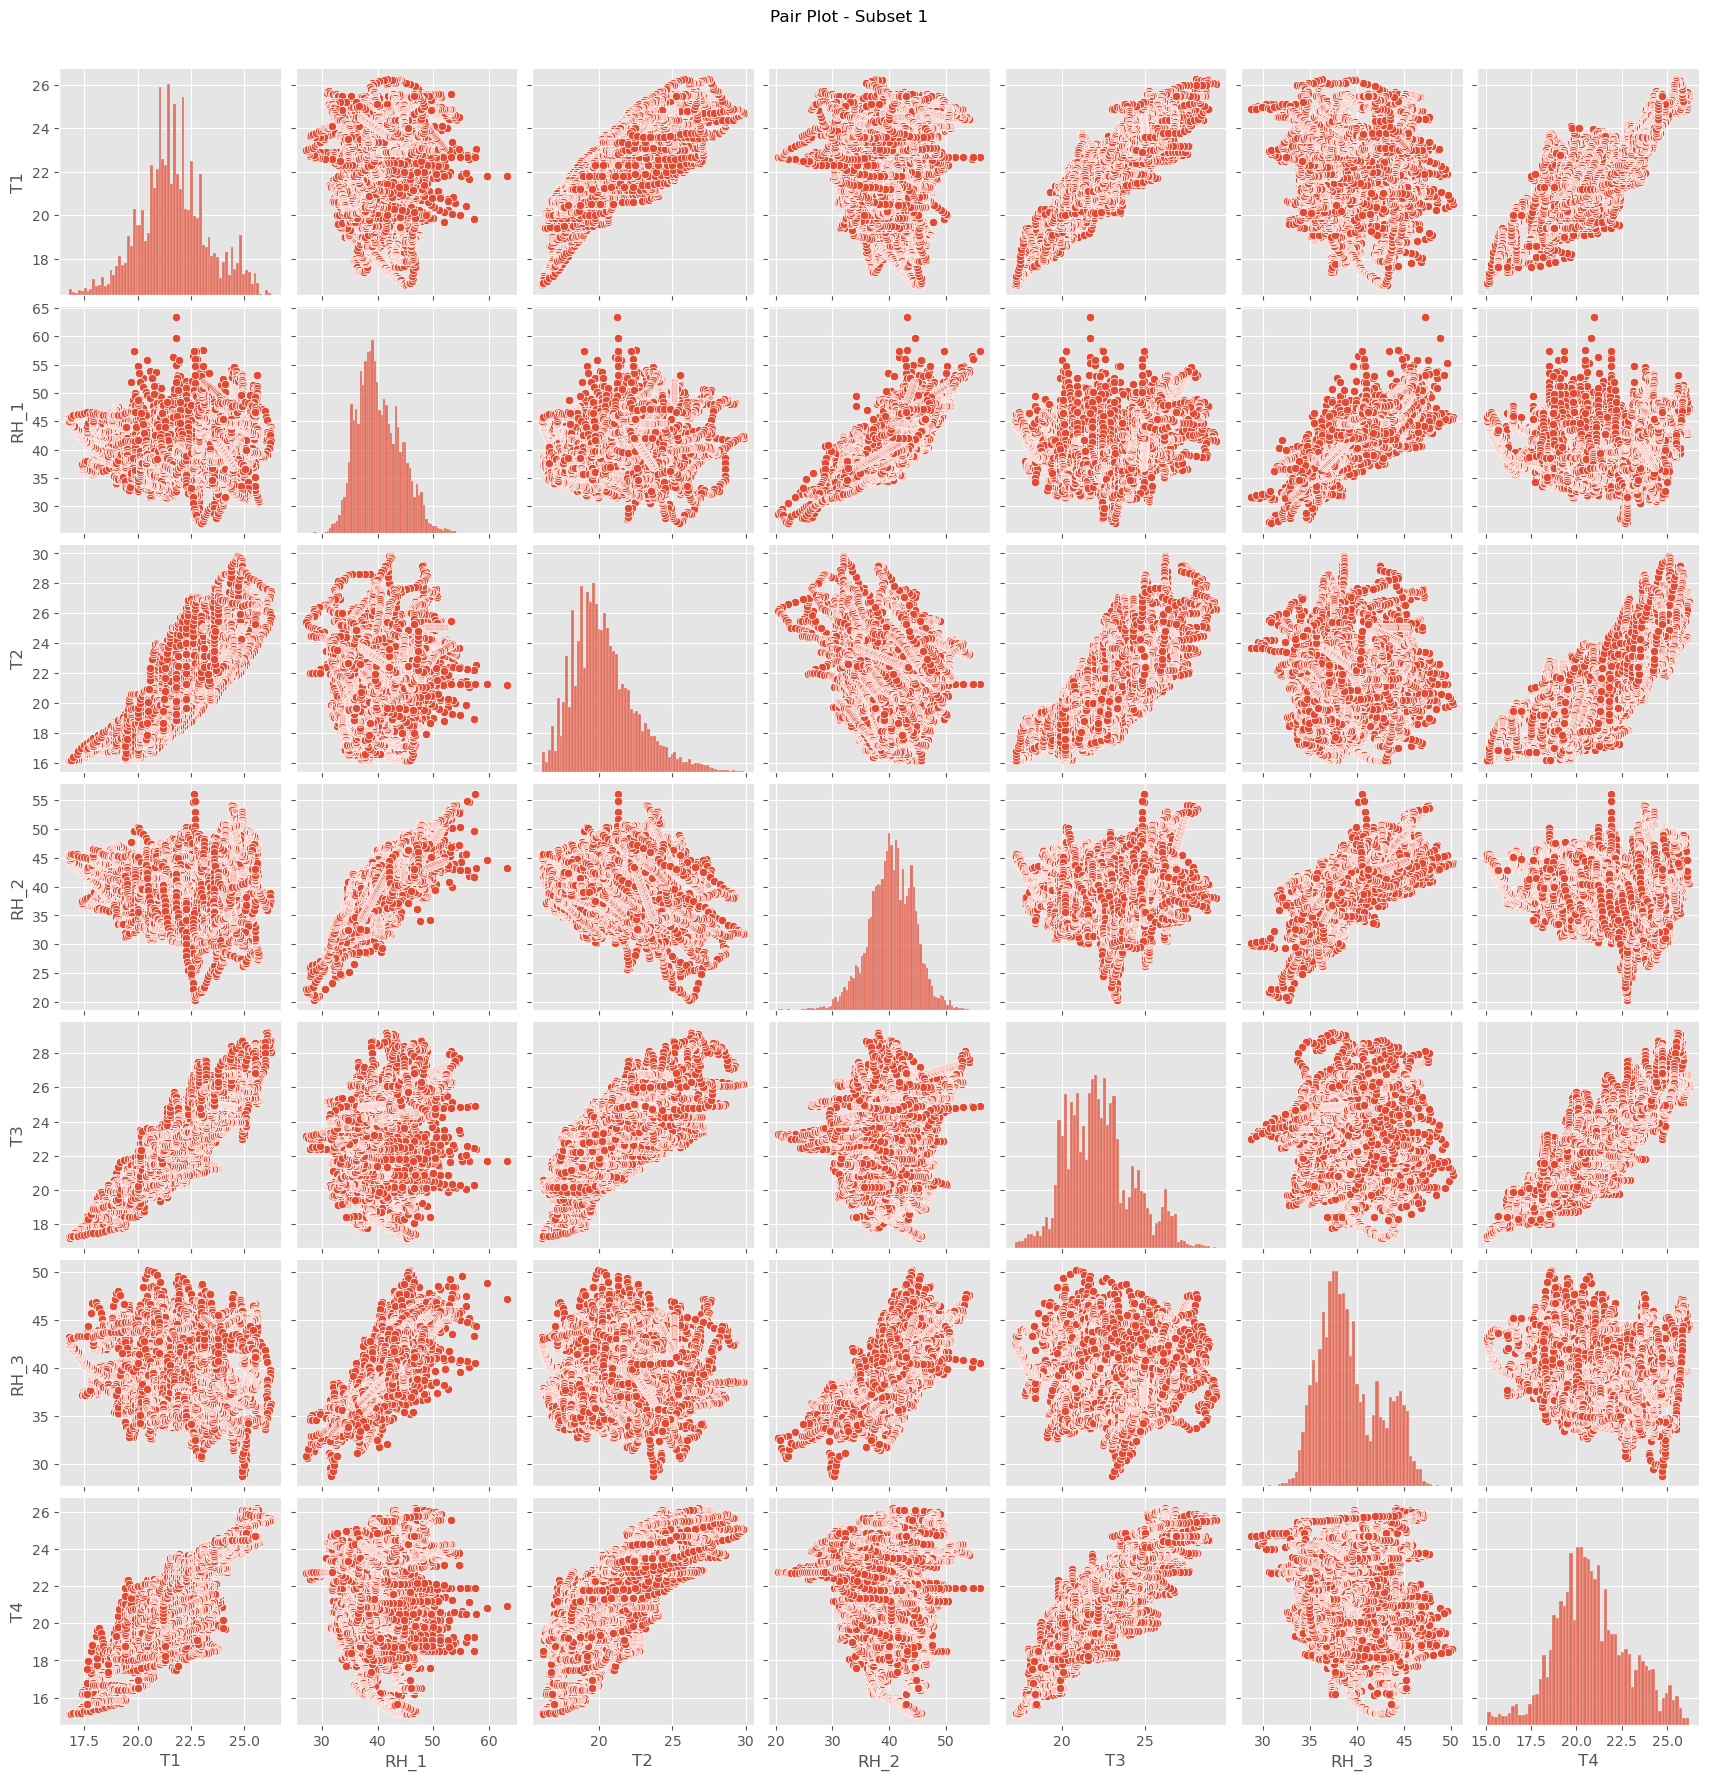

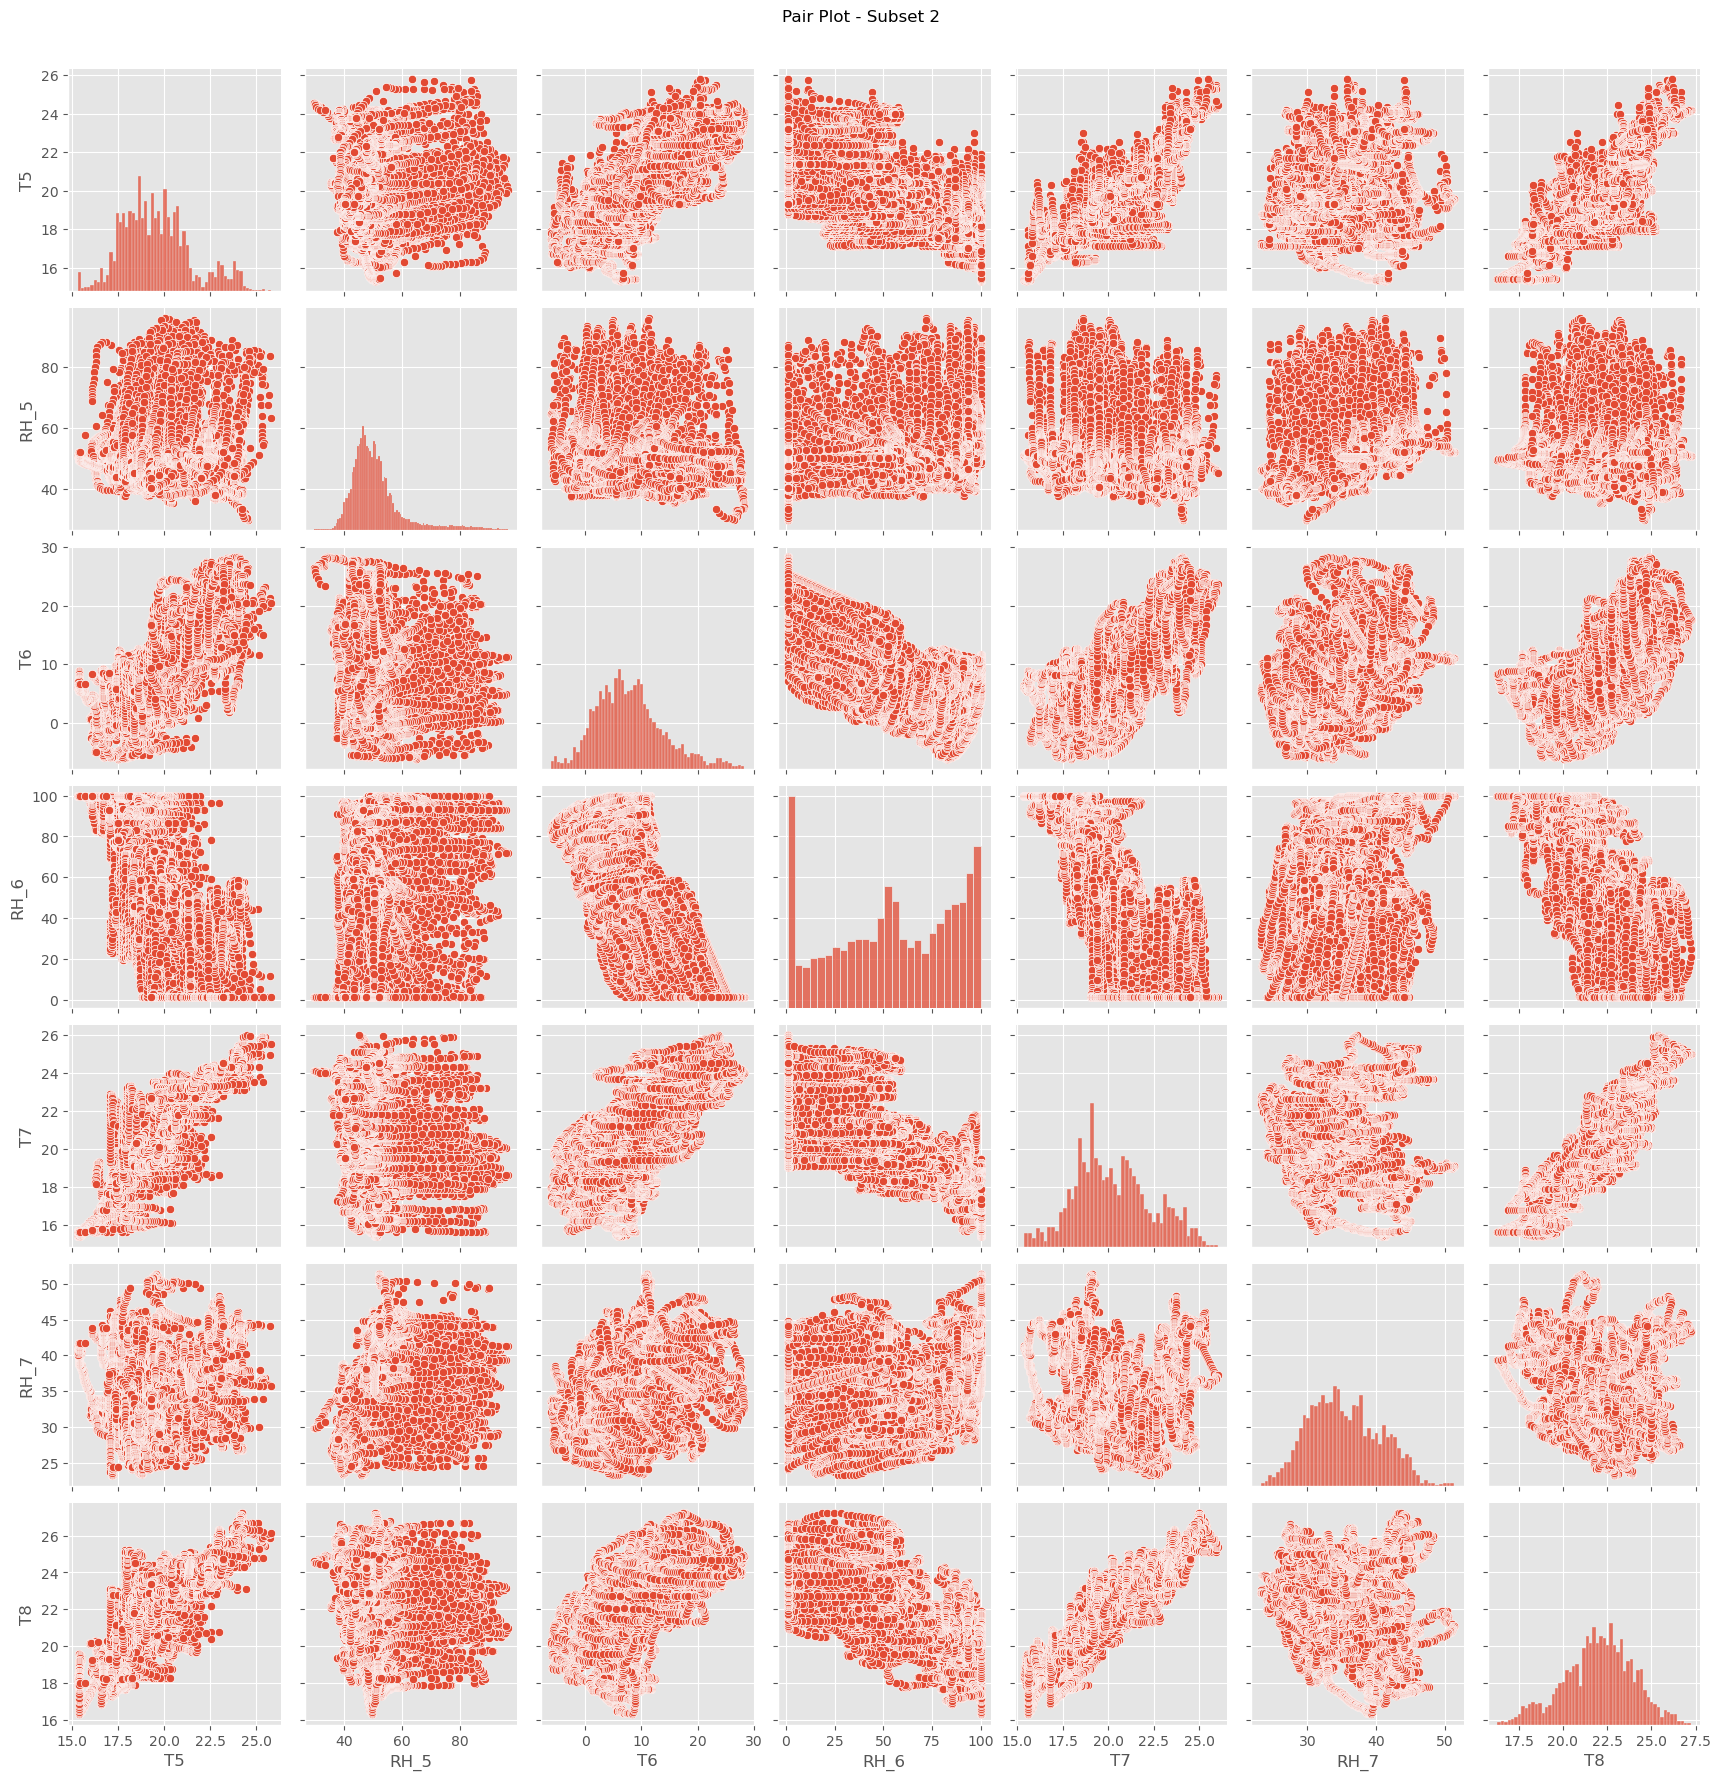

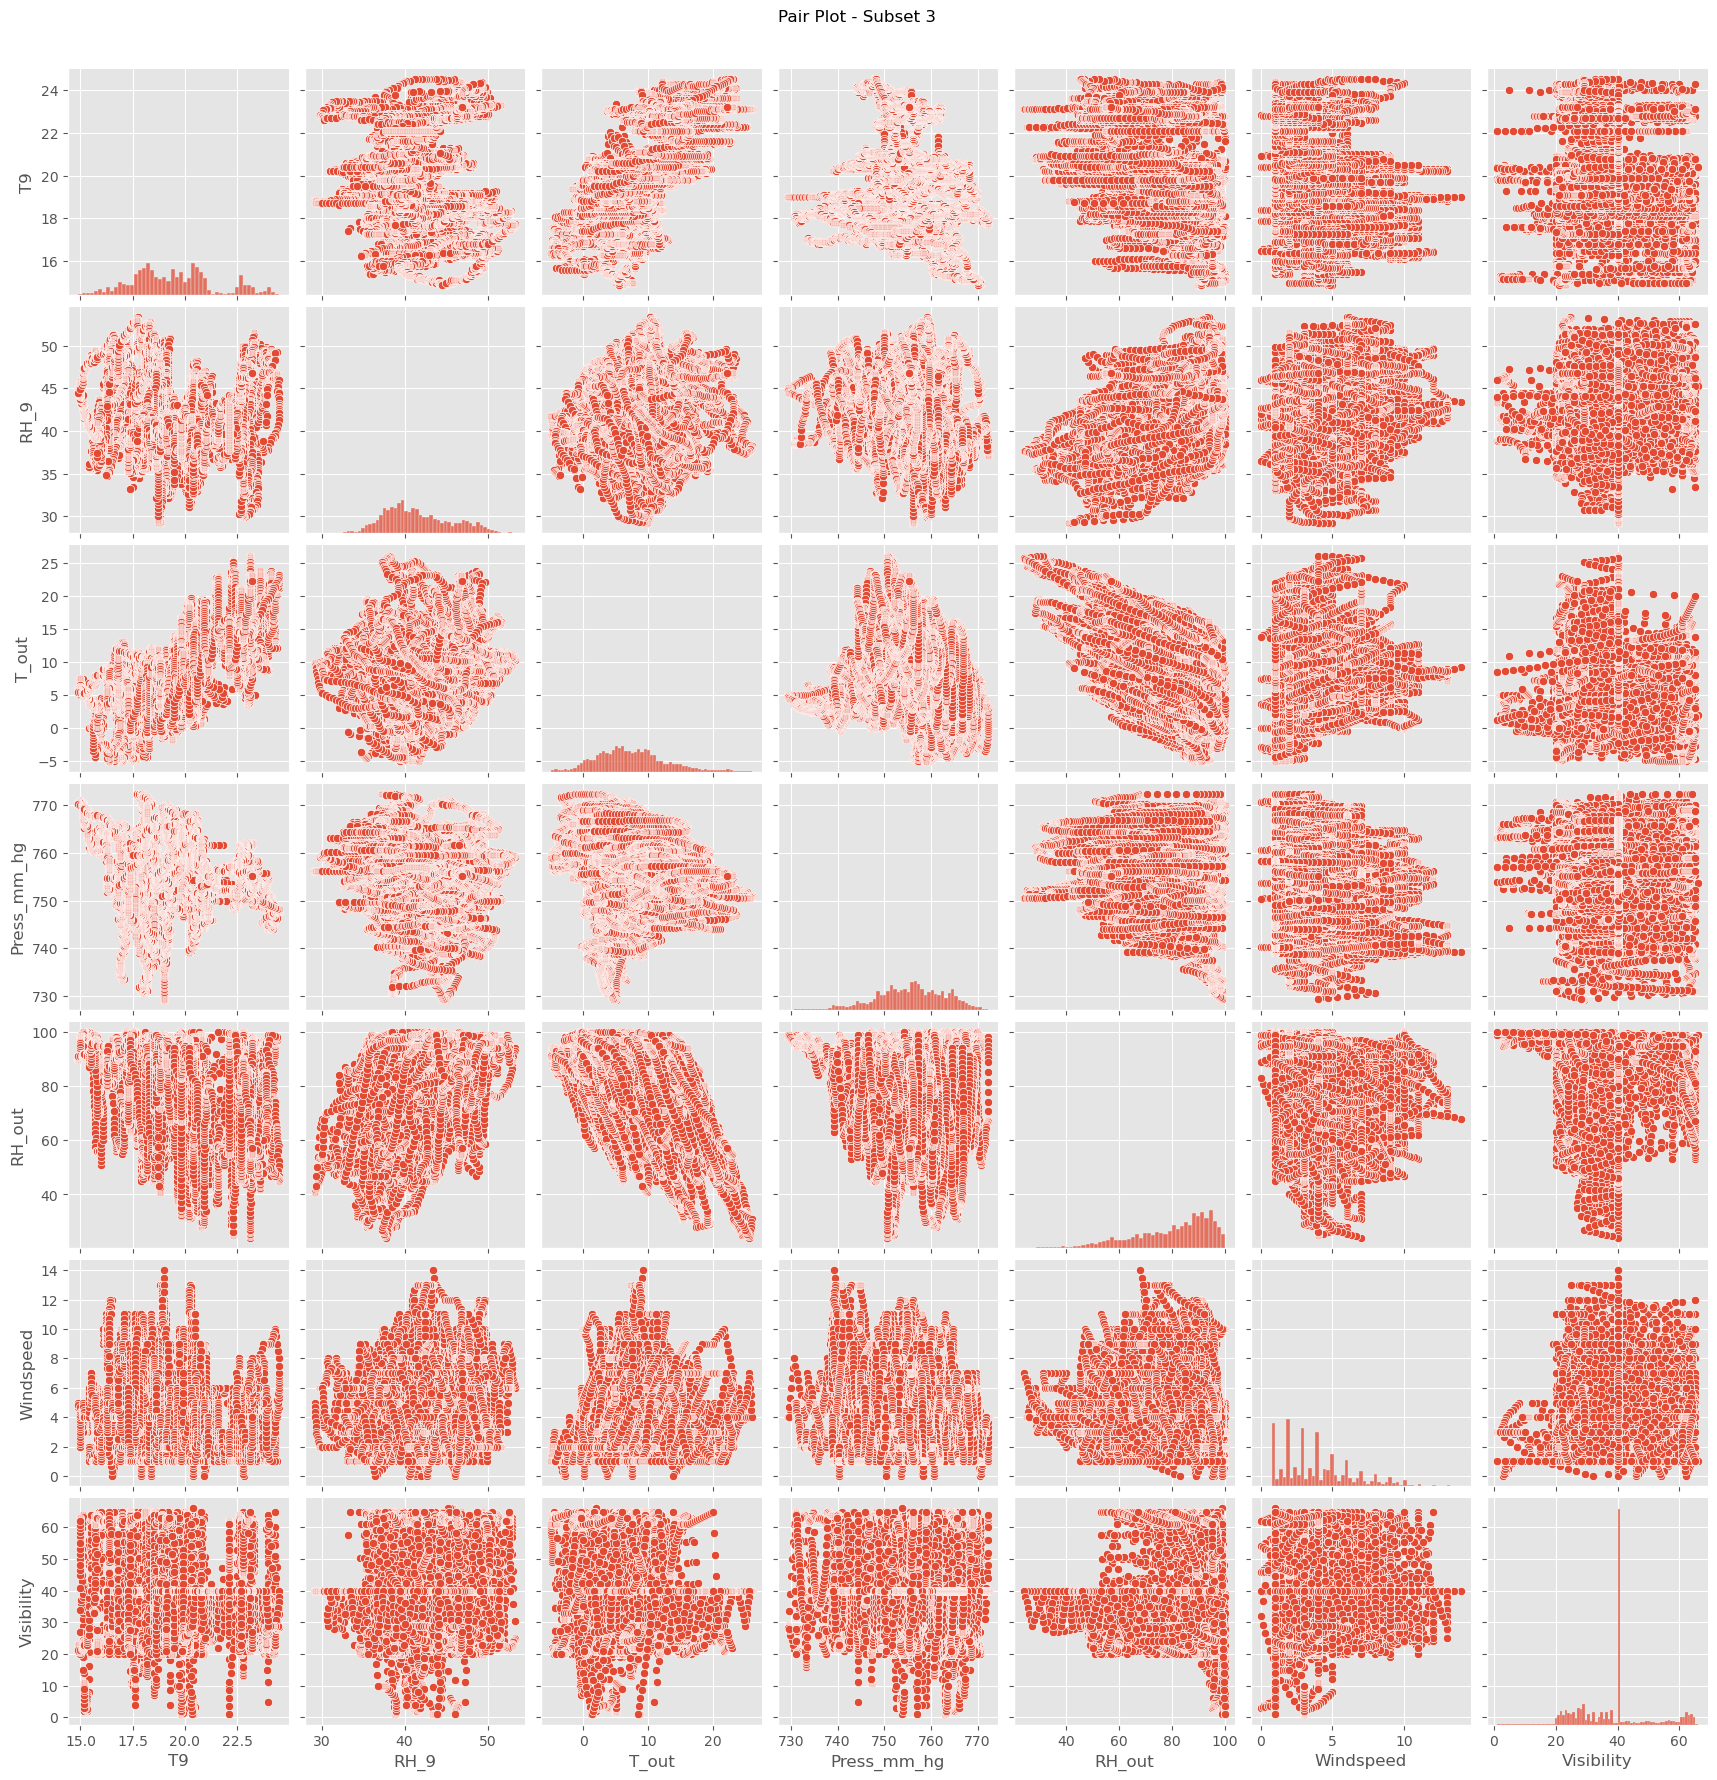

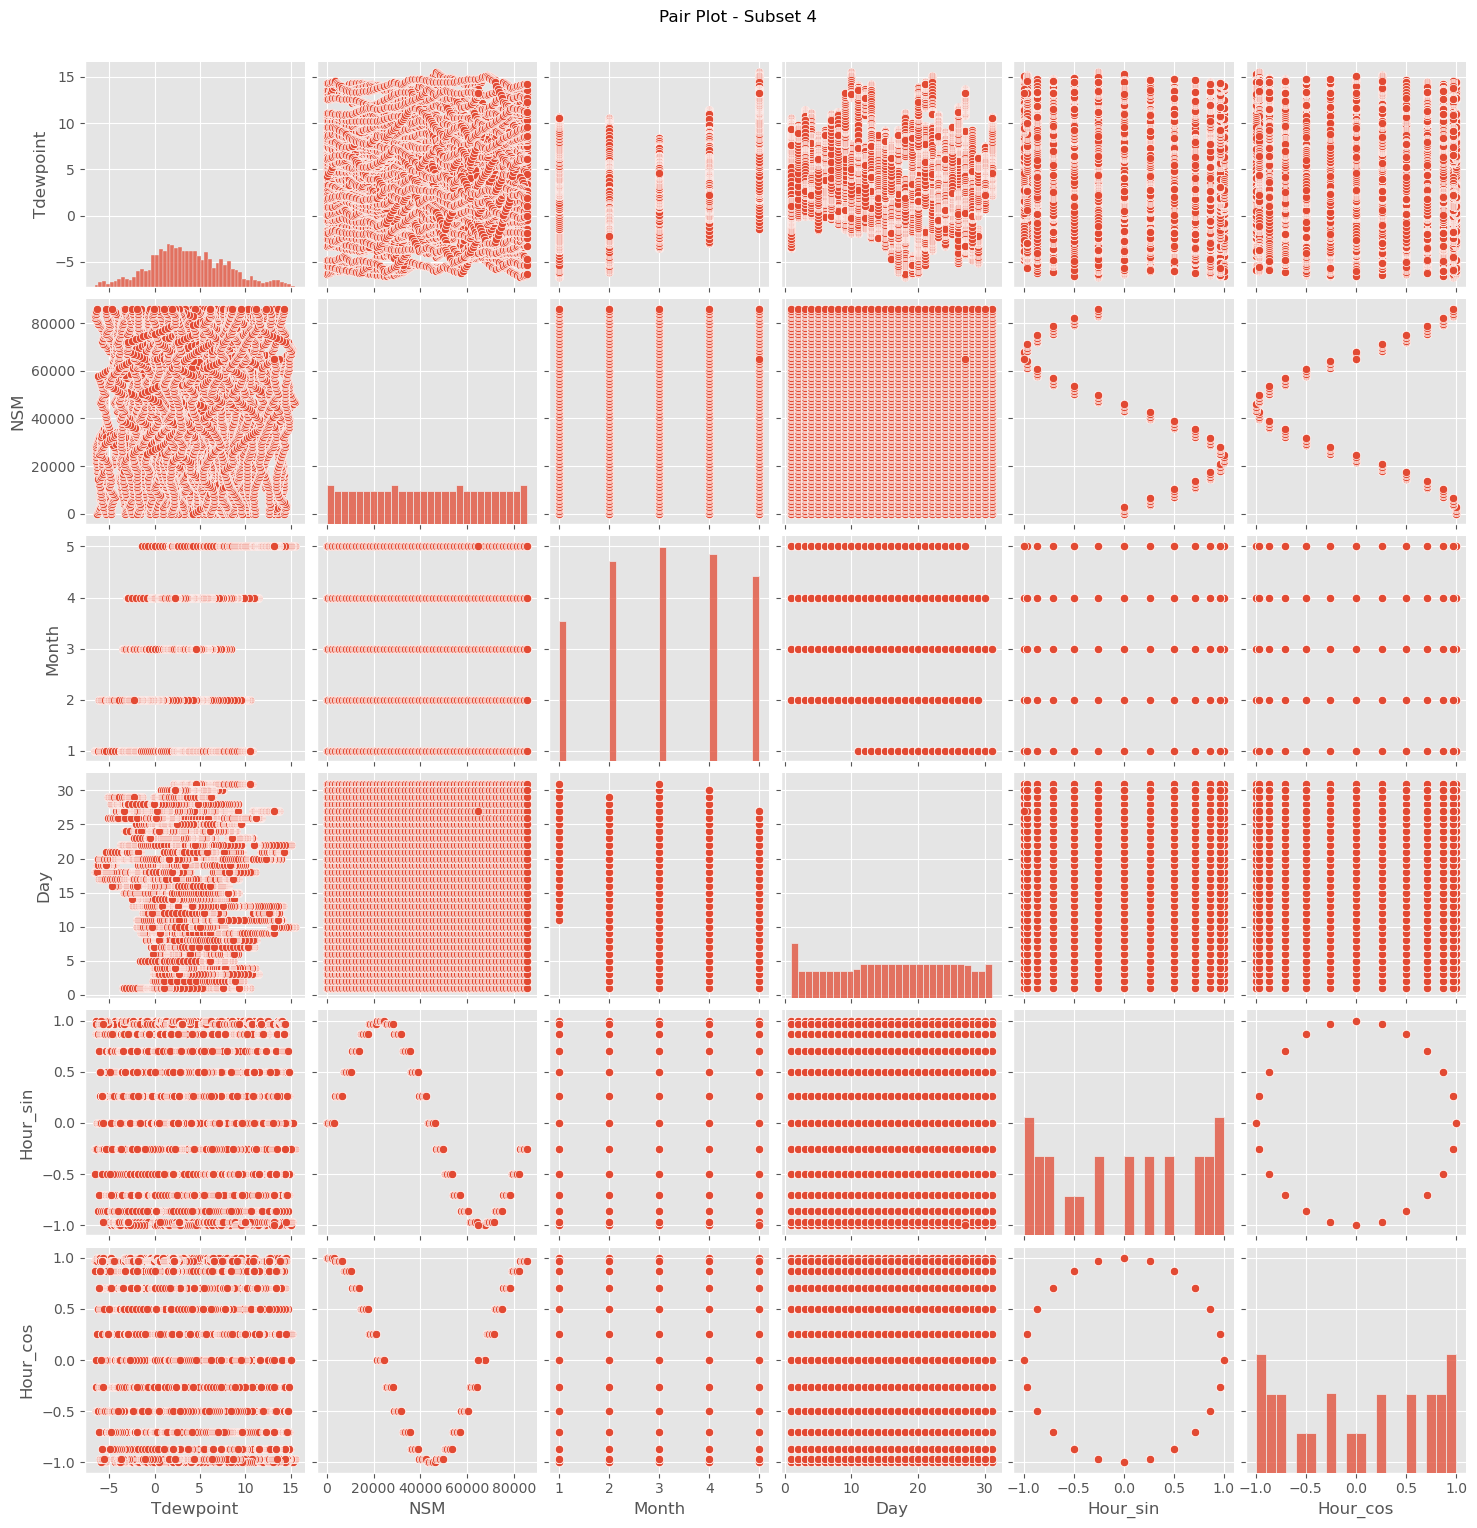

In [59]:
# Select columns for the pair plot
columns_subset_1 = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4']  # First subset of columns
columns_subset_2 = ['T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8']  # Second subset of columns
columns_subset_3 = ['T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility']  # Third subset of columns
columns_subset_4 = ['Tdewpoint', 'NSM', 'WeekStatus', 'Day_of_week', 'Month', 'Day', 'Season', 'Hour_sin', 'Hour_cos']  # Fourth subset of columns

# Pair plot for the first subset
sns.pairplot(energy_data[columns_subset_1])
plt.suptitle('Pair Plot - Subset 1', y=1.02)
plt.savefig('pairplot 1.png')
plt.show()

# Pair plot for the second subset
sns.pairplot(energy_data[columns_subset_2])
plt.suptitle('Pair Plot - Subset 2', y=1.02)
plt.savefig('pairplot 2.png')
plt.show()

# Pair plot for the third subset
sns.pairplot(energy_data[columns_subset_3])
plt.suptitle('Pair Plot - Subset 3', y=1.02)
plt.savefig('pairplot 3.png')
plt.show()

# Pair plot for the fourth subset
sns.pairplot(energy_data[columns_subset_4])
plt.suptitle('Pair Plot - Subset 4', y=1.02)
plt.savefig('pairplot 4.png')
plt.show()

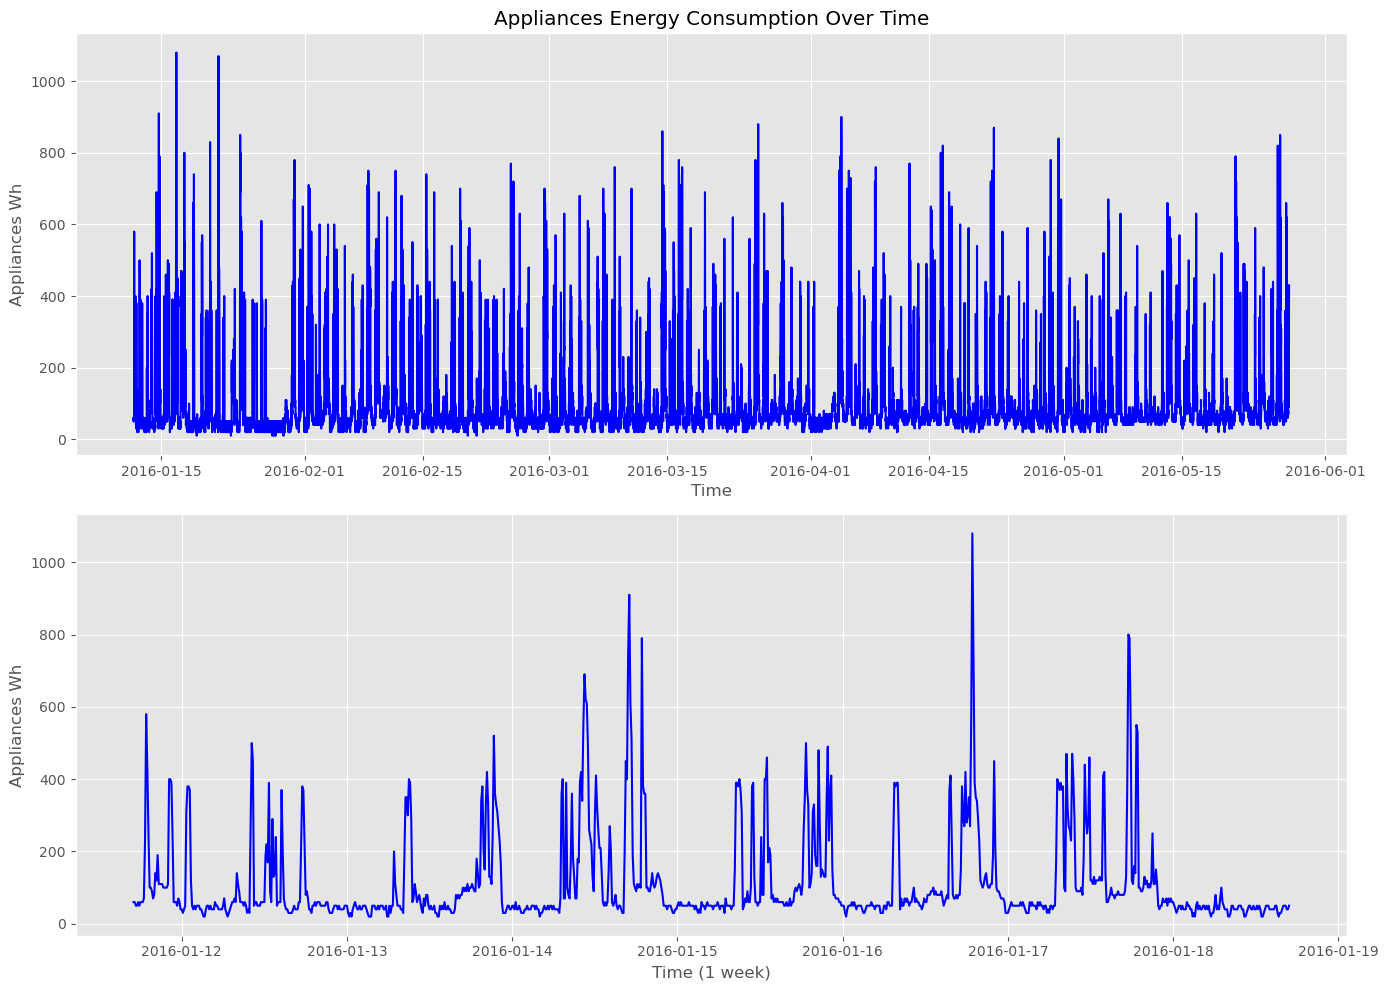

In [60]:
#  Plotting trend in Appliance energy consumption
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(energy_data['date'], energy_data['Appliances'], color='blue')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.title('Appliances Energy Consumption Over Time')

plt.subplot(2, 1, 2)
plt.plot(energy_data['date'][:1008], energy_data['Appliances'][:1008], color='blue')
plt.xlabel('Time (1 week)')
plt.ylabel('Appliances Wh')

plt.tight_layout()
plt.savefig('Appliances_profile_3_Jan29.png', dpi=300)
plt.show()

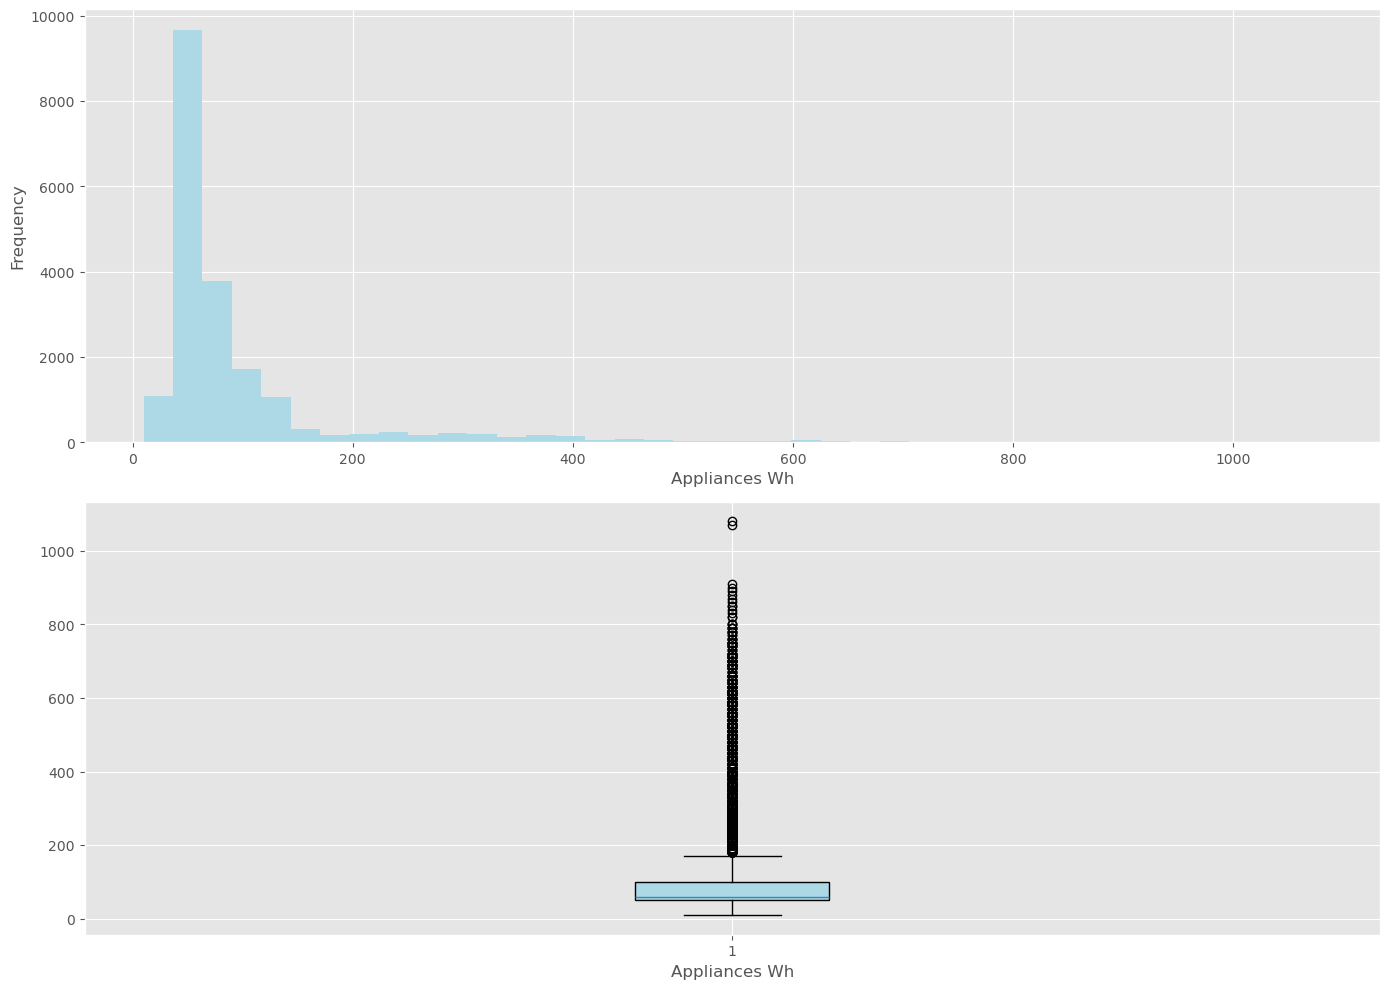

In [61]:
# Histogram of Appliance energy consumption
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.hist(energy_data['Appliances'], bins=40, color='lightblue')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.boxplot(energy_data['Appliances'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel('Appliances Wh')

plt.tight_layout()
plt.savefig('Appliances_histogram_boxplot2_Jan29.png', dpi=300)
plt.show()

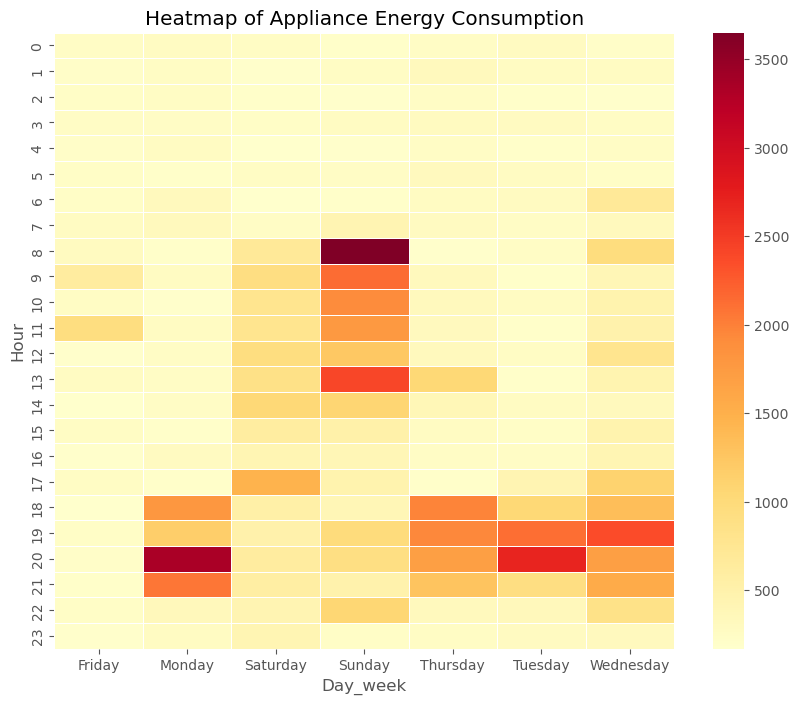

In [62]:
import calendar

# Create new time variables
energy_data['my'] = energy_data['date'].dt.to_period('M')
energy_data['mhr'] = energy_data['date'].dt.to_period('H')

hourly_data = energy_data.groupby('mhr').agg({'Appliances': 'sum'}).reset_index()
hourly_data['Day_week'] = hourly_data['mhr'].dt.dayofweek
hourly_data['Hour'] = hourly_data['mhr'].dt.hour

# Convert the 'mhr' period to a timestamp and then extract the week number
hourly_data['week_year'] = hourly_data['mhr'].dt.start_time.dt.isocalendar().week

# Map the day of the week to actual names
hourly_data['Day_week'] = hourly_data['Day_week'].map({i: day for i, day in enumerate(calendar.day_name)})

# Filter for the specific week
weekly_data = hourly_data[hourly_data['week_year'] == 3]

# Create the heatmap
plt.figure(figsize=(10, 8))
pivot = weekly_data.pivot_table(values='Appliances', index='Hour', columns='Day_week', aggfunc='sum')
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5)
plt.title('Heatmap of Appliance Energy Consumption')
plt.savefig('heatmap_Jan29.png', dpi=300)
plt.show()


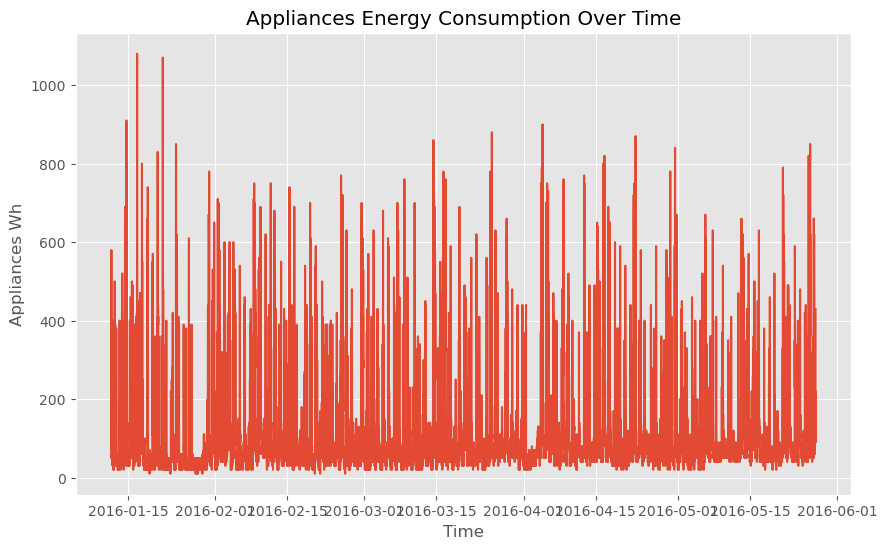

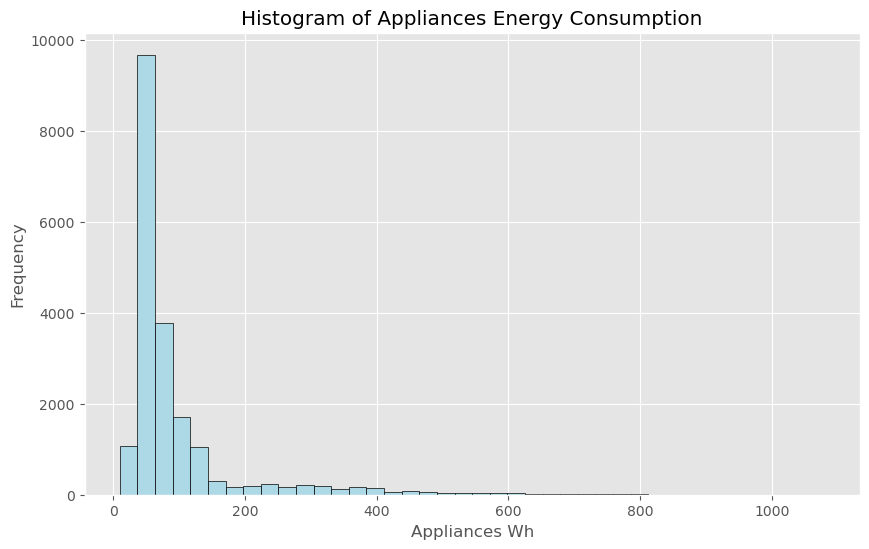

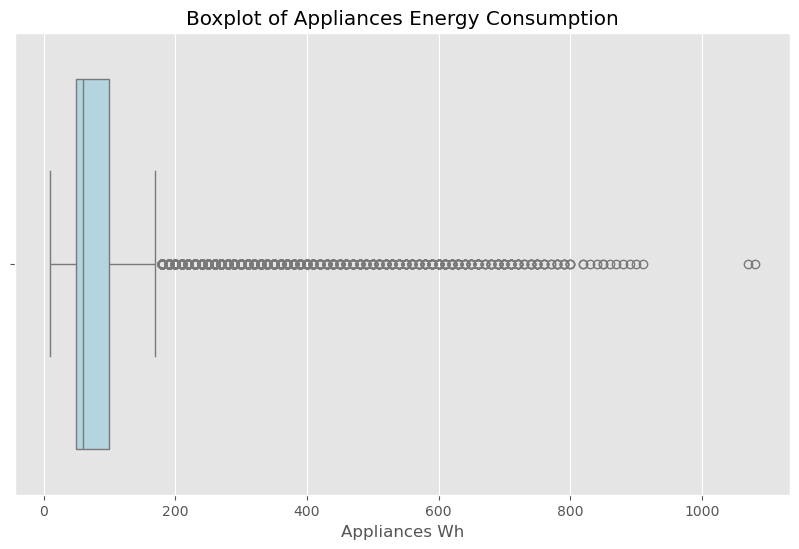

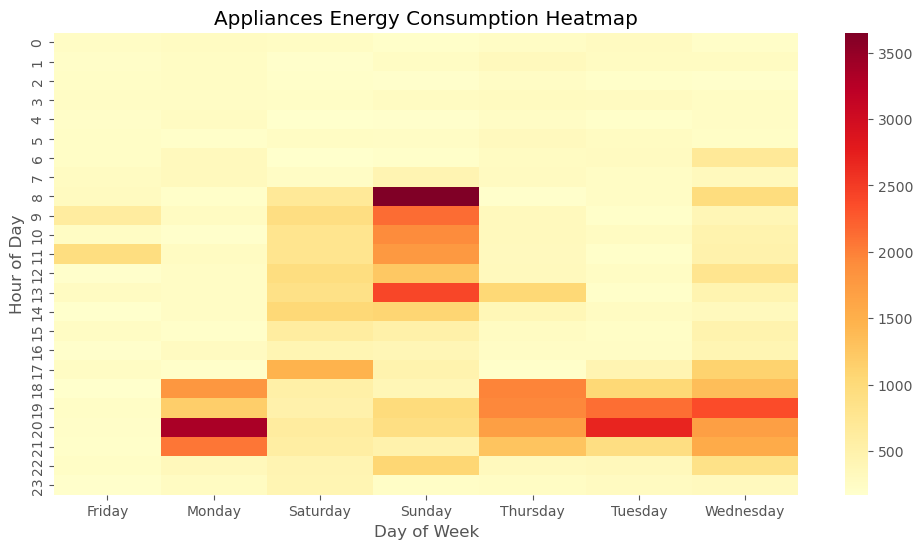

In [63]:
# Appliances profile plot
plt.figure(figsize=(10, 6))
plt.plot(energy_data['date'], energy_data['Appliances'], label='Appliances')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.title('Appliances Energy Consumption Over Time')
plt.savefig('Appliances Energy Consumption Over Time.png', dpi=300)

plt.show()

# Boxplot and Histogram
plt.figure(figsize=(10, 6))
plt.hist(energy_data['Appliances'], bins=40, color='lightblue', edgecolor='black')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')
plt.title('Histogram of Appliances Energy Consumption')
plt.savefig('Histogram of Appliances Energy Consumption.png', dpi=300)

plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=energy_data, x='Appliances', color='lightblue')
plt.xlabel('Appliances Wh')
plt.title('Boxplot of Appliances Energy Consumption')
plt.savefig('Boxplot of Appliances Energy Consumption.png', dpi=300)
plt.show()

# Heat map visualization for a specific week
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['week_year'] = energy_data['date'].dt.isocalendar().week
energy_data_w1 = energy_data[energy_data['week_year'] == 3]

heatmap_data = energy_data_w1.pivot_table(values='Appliances', index='Hour', columns='Day_of_week', aggfunc=np.sum)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('Appliances Energy Consumption Heatmap')
plt.savefig('Appliances Energy Consumption Heatmap.png', dpi=300)
plt.show()

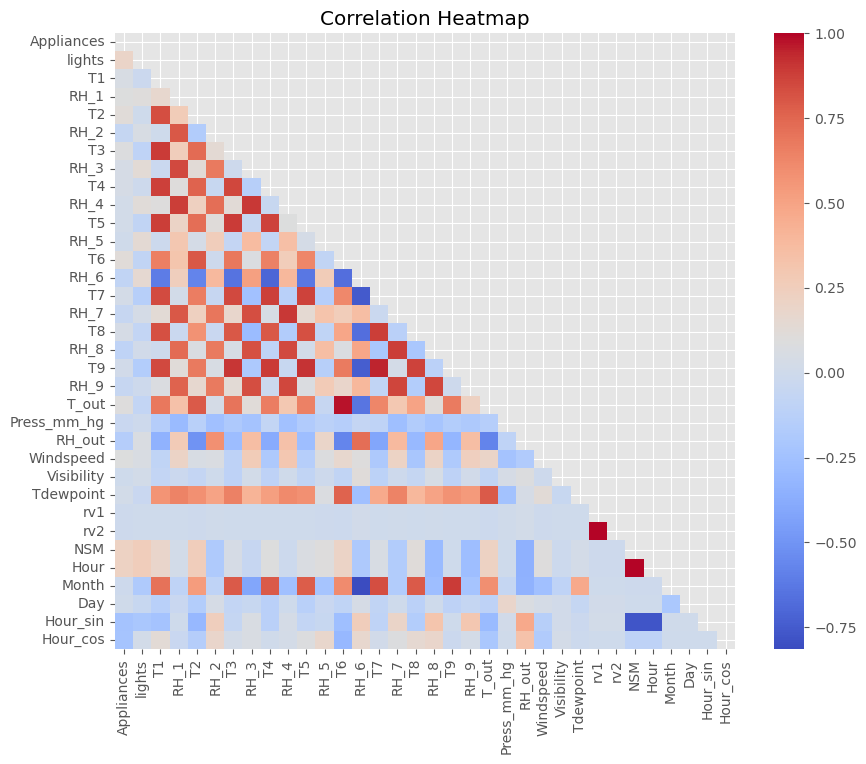

In [64]:
# Correlation heatmap of numeric columns
corr = energy_data.select_dtypes(['int', 'float']).corr()
matrix = np.triu(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', mask=matrix)
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap.png', dpi=300)
plt.show()

# Modelling

In [65]:
# Drop unrequired columns
data = energy_data.drop(columns=['my', 'mhr', 'date', 'week_year'])

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Appliances   19735 non-null  int64   
 1   lights       19735 non-null  int64   
 2   T1           19735 non-null  float64 
 3   RH_1         19735 non-null  float64 
 4   T2           19735 non-null  float64 
 5   RH_2         19735 non-null  float64 
 6   T3           19735 non-null  float64 
 7   RH_3         19735 non-null  float64 
 8   T4           19735 non-null  float64 
 9   RH_4         19735 non-null  float64 
 10  T5           19735 non-null  float64 
 11  RH_5         19735 non-null  float64 
 12  T6           19735 non-null  float64 
 13  RH_6         19735 non-null  float64 
 14  T7           19735 non-null  float64 
 15  RH_7         19735 non-null  float64 
 16  T8           19735 non-null  float64 
 17  RH_8         19735 non-null  float64 
 18  T9           19735 non-nul

In [67]:
data.head()

Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   
3          50      40  19.89  46.066667  19.2  44.590000  19.79  45.000000   
4          60      40  19.89  46.333333  19.2  44.530000  19.79  45.000000   

          T4       RH_4  ...        rv2    NSM  WeekStatus  Day_of_week  Hour  \
0  19.000000  45.566667  ...  13.275433  61200     Weekday       Monday    17   
1  19.000000  45.992500  ...  18.606195  61800     Weekday       Monday    17   
2  18.926667  45.890000  ...  28.642668  62400     Weekday       Monday    17   
3  18.890000  45.723333  ...  45.410389  63000     Weekday       Monday    17   
4  18.890000  45.530000  ...  10.084097  63600     Weekday       Monday    17   

   Month  Day  Season  Hour_sin  Hour_cos  
0      1   11  Winter -0.965926 -0.258819  
1      1   11  Winter -0.965926 -0.258819  
2      1   11  Winter -0.965926 -0.258819  
3      1   11  Winter -0.965926 -0.258819  
4      1   11  Winter -0.965926 -0.258819  

[5 rows x 37 columns]

### Preprocessing

In [68]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
categorical_cols = data.select_dtypes('category').columns.to_list()

In [69]:
# Encode categorical columns
train = pd.get_dummies(train_data, columns=categorical_cols)
test = pd.get_dummies(test_data, columns=categorical_cols)
train[train.select_dtypes('bool').columns] = train.select_dtypes('bool').astype(int)
test[test.select_dtypes('bool').columns] = test.select_dtypes('bool').astype(int)

In [70]:
# Model training
features = [col for col in train.columns if col not in ['Appliances']]

# Models Training

In [71]:
# Splitting training set 
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features]) # Standardize X Values
y_train = train['Appliances']

pd.DataFrame(X_train, columns=features).to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Splitting testing set 
X_test = scaler.transform(test[features]) # Standardize X Values
y_test = test['Appliances']

pd.DataFrame(X_test, columns=features).to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [72]:
# Defining a function to print Metrics
def print_metrics(model_name, grid=None):
    train_pred = model_name.predict(X_train)
    test_pred = model_name.predict(X_test)
    print(f'Training Set\nRMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
    print(f'MAE: {mean_absolute_error(y_train, train_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_train, train_pred)}')
    print(f'R2: {r2_score(y_train, train_pred)}\n\nTesting Set')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')
    print(f'MAE: {mean_absolute_error(y_test, test_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test, test_pred)}')
    print(f'R2: {r2_score(y_test, test_pred)}')
    if grid:
        print(f'\n\nBest Estimator: {grid.best_estimator_}')
        print(f'Best Parameters: {grid.best_params_}')


## 1. Linear Regression

### Training

In [73]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Save the tuned model
joblib.dump(lr, 'best_lr.pkl')

# Predictions
y_pred_train_slr = lr.predict(X_train)

### Model evaluation and Feature importance 

In [74]:
print_metrics(lr)

Training Set
RMSE: 91.94963212931218
MAE: 51.89251146303652
MAPE: 0.5898851168764979
R2: 0.2100426923470713

Testing Set
RMSE: 89.38666210764491
MAE: 51.95173977531586
MAPE: 0.6174202762022697
R2: 0.19568275641118738


## 2. RandomForest Model

### Training

In [75]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predictions
y_pred_train_srf = rf.predict(X_train)

### Hyper-parameter Tuning

In [76]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5]
}
rf_grid = HalvingRandomSearchCV(rf, rf_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
joblib.dump(best_rf, 'best_rf.pkl')

print_metrics(best_rf, rf_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 20
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 1
n_resources: 180
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Training Set
RMSE: 25.649224422954546
MAE: 12.130494561178299
MAPE: 0.1193085823626859
R2: 0.9385315723785143

Testing Set
RMSE: 65.72010182237064
MAE: 31.592338873125254
MAPE: 0.31751415981158243
R2: 0.5652111535871001


Best Estimator: RandomForestRegressor(n_estimators=200)
Best Parameters: {'n_estimators': 200, 'max_depth': None}


## 3. Gradient Boosting

### Training

In [77]:
# Gradient Boosting Regressor
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_pred_train_sgbm = gbm.predict(X_train)

### Hyperparameter Tuning

In [78]:
# Hyperparameter tuning for Gradient Boosting
gbm_param_grid = {
    'n_estimators': [200, 500, 1000, 10000],
    'max_depth': [2, 5, 8]
}
gbm_grid = HalvingRandomSearchCV(gbm, gbm_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
gbm_grid.fit(X_train, y_train)
best_gbm = gbm_grid.best_estimator_
joblib.dump(best_gbm, 'best_gbm.pkl')

print_metrics(best_gbm, gbm_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 83.38669849324816
MAE: 45.45405158516846
MAPE: 0.49818793770096476
R2: 0.35032345573872825

Testing Set
RMSE: 83.9225739046007
MAE: 46.47903235531501
MAPE: 0.5284208965060013
R2: 0.29101094669628913


Best Estimator: GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)
Best Parameters: {'n_estimators': 200, 'max_depth': 2}


## 4. Support Vector Machines

### Training

In [79]:
svm = SVR(kernel="linear")
svm.fit(X_train, y_train)

# Predcition
y_pred_train_ssvm = svm.predict(X_train)

### Hyper-parameter tuning

In [80]:
# Hyperparameter tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 500, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}
svm_grid = HalvingRandomSearchCV(svm, svm_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
joblib.dump(best_svm, 'best_svm.pkl')

print_metrics(best_svm, svm_grid)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 20
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 60
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 180
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 3
n_resources: 540
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Training Set
RMSE: 83.79097208073082
MAE: 32.30367477391103
MAPE: 0.23375969881435768
R2: 0.34400868966875175

Testing Set
RMSE: 83.03136742374254
MAE: 34.39857668766255
MAPE: 0.2731653489307305
R2: 0.30598905447879743


Best Estimator: SVR(C=1000, gamma=0.01)
Best Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}


## 5. Decision Tree Regressor


### Training

In [81]:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)

# Predictions
y_pred_train_sdt = dt.predict(X_train)

### Hyperparameter Tuning

In [82]:
dt_param_grid = {
    'max_depth': [10, 20, 50, 100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse']
}

dt_grid = HalvingRandomSearchCV(dt, dt_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
joblib.dump(best_dt, 'best_dt.pkl')

print_metrics(best_dt, dt_grid)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 7
min_resources_: 10
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 10
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 30
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 90
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 270
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 810
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training Set
RMSE: 47.59587675156352
MAE: 20.15062259843018
MAPE: 0.17841516410693503
R2: 0.7883382944197869

Testing Set
RMSE: 85.49612728665946
MAE: 39.192761113363055
MAPE: 0.37881976575467746
R2: 0.26417451507922884


Best Estimator: DecisionTreeRegressor(min_samples_leaf=4, min_sa

## 6. Extra Trees Regressor

### Training

In [83]:
# Training Extra Trees Regressor
et = ExtraTreesRegressor(random_state=1)
et.fit(X_train, y_train)

# Predictions
y_pred_train_set = et.predict(X_train)

### Hyperparameter Tuning for Extra Trees

In [ ]:
et_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
et_grid = HalvingRandomSearchCV(et, et_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
et_grid.fit(X_train, y_train)
best_et = et_grid.best_estimator_
joblib.dump(best_et, 'best_et.pkl')

print_metrics(best_et, et_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 20
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 21.15424648376903
MAE: 9.905162254940365
MAPE: 0.09890132948930377
R2: 0.9581882110554045

Testing Set
RMSE: 63.28087882138981
MAE: 29.855750859392913
MAPE: 0.296846417801655
R2: 0.5968868708461896


Best Estimator: ExtraTreesRegressor(max_depth=20, min_samples_split=5, random_state=1)
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


## 7. Neural Network

### Training

In [ ]:
nn = MLPRegressor(random_state=1)
nn.fit(X_train, y_train)

# Predictions
y_pred_train_snn = nn.predict(X_train)

### Hyperparameter Tuning for Neural Network

In [ ]:
# parameters
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

nn_grid = HalvingRandomSearchCV(nn, nn_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
nn_grid.fit(X_train, y_train)
best_nn = nn_grid.best_estimator_
joblib.dump(best_nn, 'best_nn.pkl')

print_metrics(best_nn, nn_grid)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 20
Fitting 10 folds for each of 288 candidates, totalling 2880 fits
----------
iter: 1
n_candidates: 96
n_resources: 60
Fitting 10 folds for each of 96 candidates, totalling 960 fits
----------
iter: 2
n_candidates: 32
n_resources: 180
Fitting 10 folds for each of 32 candidates, totalling 320 fits
----------
iter: 3
n_candidates: 11
n_resources: 540
Fitting 10 folds for each of 11 candidates, totalling 110 fits
----------
iter: 4
n_candidates: 4
n_resources: 1620
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 5
n_candidates: 2
n_resources: 4860
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 74.59188643105078
MAE: 40.92621393153156
MAPE: 0.44254039062465717
R2: 0.48013951206709626

Testing Set
RMSE: 78.50833785845047
MAE: 43.40821

## 8. XGBOOST

### Training

In [ ]:
# Training XGB Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Predictions
y_pred_train_sxgb = xgb.predict(X_train)

### Hyperparameter Tuning for XG Boost

In [ ]:
# Parameter grid for XGBoost (XGB)
xgb_param_grid = {
    'n_estimators': [200, 400, 500],
    'max_depth': [4, 6, 7, 8, 5],
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0, 2, 5]
}
xgb_grid = HalvingRandomSearchCV(xgb, xgb_param_grid, cv=10, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
joblib.dump(best_xgb, 'best_xgb.pkl')

print_metrics(best_xgb, xgb_grid)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 20
max_resources_: 14801
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 20
Fitting 10 folds for each of 15 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 10 folds for each of 5 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Training Set
RMSE: 2.1367427024980628
MAE: 1.5481039230488949
MAPE: 0.02457757823290268
R2: 0.9995734095573425

Testing Set
RMSE: 64.3553448626628
MAE: 31.841429137874336
MAPE: 0.32505611423575037
R2: 0.5830814838409424


Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
 

# Models Comparison

In [ ]:
# Predict training set using best model
lr_pred_train = lr.predict(X_train)
rf_pred_train = best_rf.predict(X_train)
svm_pred_train = best_svm.predict(X_train)
gbm_pred_train = best_gbm.predict(X_train)
dt_pred_train = best_dt.predict(X_train)
et_pred_train = best_et.predict(X_train)
nn_pred_train = best_nn.predict(X_train)
xgb_pred_train = best_xgb.predict(X_train)

# Predict testing set with best model
lr_pred_test = lr.predict(X_test)
rf_pred_test = best_rf.predict(X_test)
svm_pred_test = best_svm.predict(X_test)
gbm_pred_test = best_gbm.predict(X_test)
dt_pred_test = best_dt.predict(X_test)
et_pred_test = best_et.predict(X_test)
nn_pred_test = best_nn.predict(X_test)
xgb_pred_test = best_xgb.predict(X_test)

In [ ]:
# Create a dataframe of metrics
model_predictions_train = {
    'LM': lr_pred_train,
    'SVM': svm_pred_train,
    'GBM': gbm_pred_train,
    'RF': rf_pred_train,
    'XGB': xgb_pred_train,
    'ET': et_pred_train,
    'DT': dt_pred_train,
    'NN': nn_pred_train,
}

model_predictions_test = {
    'LM': lr_pred_test,
    'SVM': svm_pred_test,
    'GBM': gbm_pred_test,
    'RF': rf_pred_test,
    'XGB': xgb_pred_test,
    'ET': et_pred_test,
    'DT': dt_pred_test,
    'NN': nn_pred_test,
}

# Initialize an empty dictionary to store the metrics
metrics = {}

# Calculate the metrics for each model using a loop
for model_name in model_predictions_test:
    metrics[model_name] = [
        np.sqrt(mean_squared_error(y_train, model_predictions_train[model_name])),
        r2_score(y_train, model_predictions_train[model_name]),
        mean_absolute_error(y_train, model_predictions_train[model_name]),
        mean_absolute_percentage_error(y_train, model_predictions_train[model_name])*100,
        np.sqrt(mean_squared_error(y_test, model_predictions_test[model_name])),
        r2_score(y_test, model_predictions_test[model_name]),
        mean_absolute_error(y_test, model_predictions_test[model_name]),
        mean_absolute_percentage_error(y_test, model_predictions_test[model_name])*100
    ]
# Create DataFrame
metrics_df = pd.DataFrame(metrics, index=['Training RMSE', 'Training R2', 'Training MAE', 'Training MAPE',
                                                      'Testing RMSE', 'Testing R2', 'Testing MAE', 'Testing MAPE'])

metrics_df.T.to_csv('metrics_df.csv', index=True)
metrics_df.T

Training RMSE  Training R2  Training MAE  Training MAPE  Testing RMSE  \
LM       91.949632     0.210043     51.892511      58.988512     89.386662   
SVM      58.485438     0.680406     17.345030      11.752031     75.137767   
GBM      83.386698     0.350323     45.454052      49.818794     83.922574   
RF       25.313207     0.940132     12.024378      11.801274     65.514924   
XGB       2.136743     0.999573      1.548104       2.457758     64.355345   
ET       21.154246     0.958188      9.905162       9.890133     63.280879   
DT       86.459538     0.301559     34.632119      27.310288     90.528361   
NN       74.591886     0.480140     40.926214      44.254039     78.508338   

     Testing R2  Testing MAE  Testing MAPE  
LM     0.195683    51.951740     61.742028  
SVM    0.431673    33.911976     30.375934  
GBM    0.291011    46.479032     52.842090  
RF     0.567922    31.367710     31.441633  
XGB    0.583081    31.841429     32.505611  
ET     0.596887    29.855751     29.684642  
DT     0.175005    38.685651     31.843371  
NN     0.379540    43.408217     47.886887

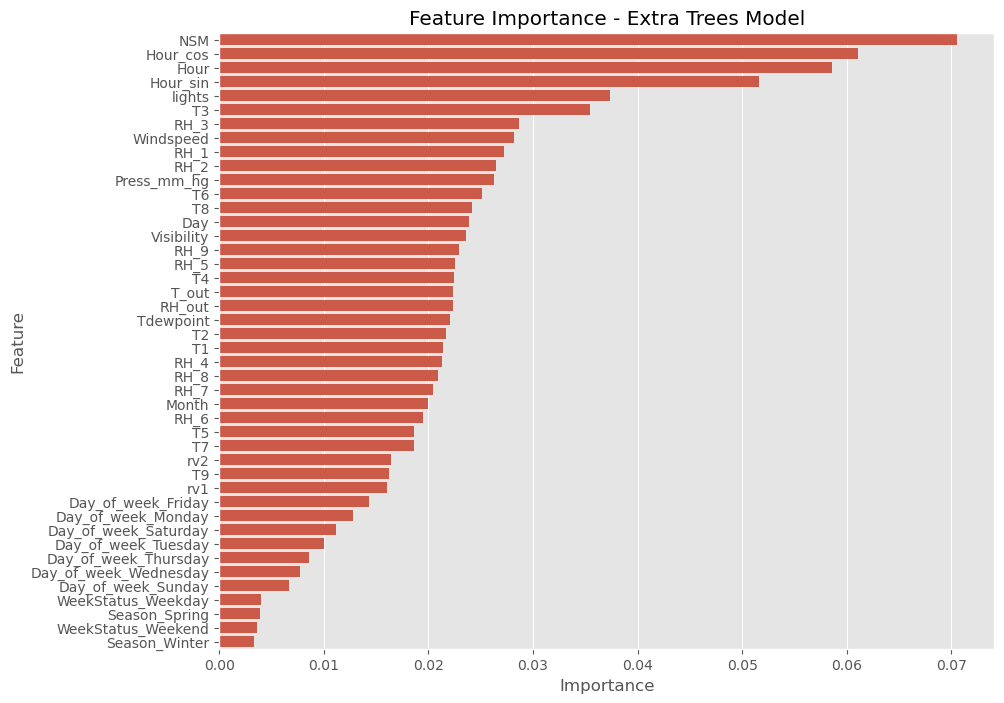

In [ ]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import partial_dependence

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

# Feature Importance
feature_importances = best_et.feature_importances_
features = train[features].columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Extra Trees Model')
plt.savefig('Feature Importance.png', dpi=300)
plt.show()

<Figure size 1200x1000 with 0 Axes>

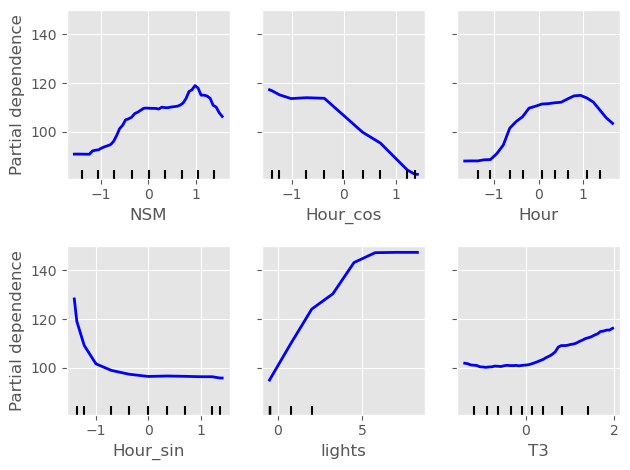

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Select the top 6 most important features for Partial Dependence Plots
top_features = importance_df['Feature'].iloc[:6].tolist()

# Set up the figure size and styling for better visualization
plt.figure(figsize=(12, 10))
plt.style.use('ggplot')  # Use ggplot style for a clean and professional look

# Plot Partial Dependence for the selected features using the trained Extra Trees model
display = PartialDependenceDisplay.from_estimator(
    best_et, 
    X_train, 
    features=top_features, 
    grid_resolution=50,
    n_cols=3,  # Arrange plots in 2 rows and 3 columns
    line_kw={"color": "blue", "lw": 2},  # Line color and width
)

# Customize the plots further if needed
for ax in display.axes_.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Add more space between rows

# Save the plot with high resolution for publication or report
plt.savefig('Partial_dependence.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

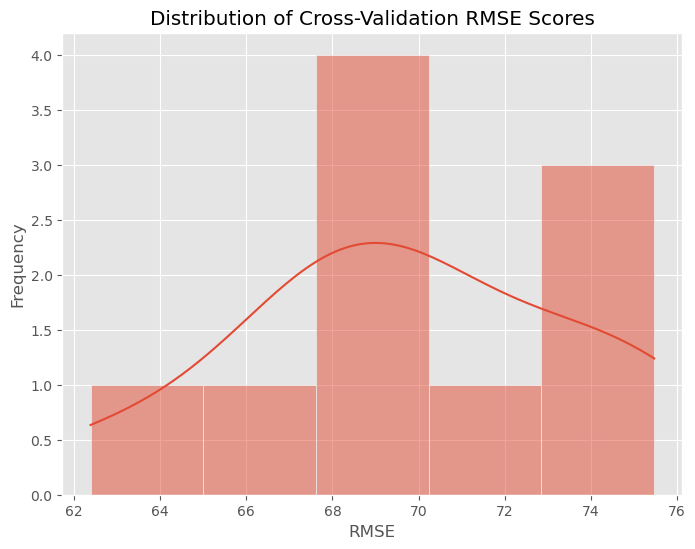

Mean CV RMSE: 69.76075868155384
Standard Deviation of CV RMSE: 3.810976038876552


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and capture results
cv_scores = cross_val_score(best_et, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Convert negative MSE to RMSE
cv_rmse_scores = (-cv_scores) ** 0.5

# Plot the distribution of RMSE scores
plt.figure(figsize=(8, 6))
sns.histplot(cv_rmse_scores, kde=True)
plt.title('Distribution of Cross-Validation RMSE Scores')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

# Print mean and standard deviation of the RMSE scores
print(f'Mean CV RMSE: {cv_rmse_scores.mean()}')
print(f'Standard Deviation of CV RMSE: {cv_rmse_scores.std()}')

In [ ]:
y_test

8980      40
2754      90
9132      50
14359     50
8875      70
        ... 
17496     60
9282      60
7471      80
610       80
12822    100
Name: Appliances, Length: 4934, dtype: int64

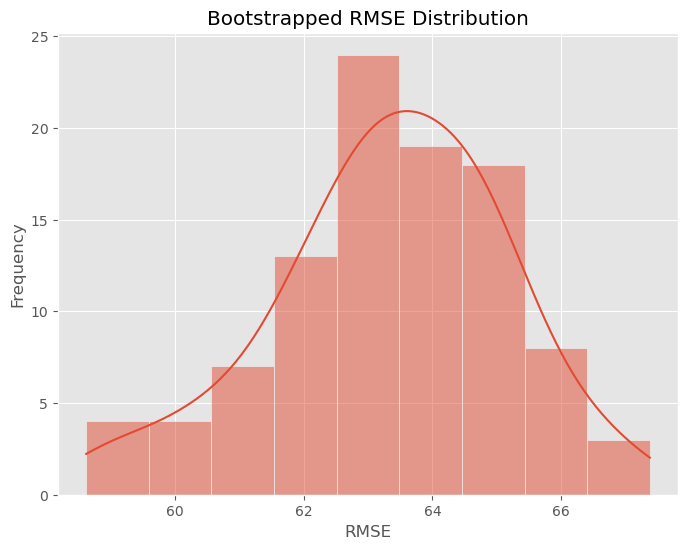

Mean Bootstrapped RMSE: 63.334736555593445
95% Confidence Interval: [59.1395575 66.5726578]


In [ ]:
from sklearn.utils import resample

# Bootstrapping to evaluate model stability
n_iterations = 100
n_size = int(len(X_test) * 0.8)

bootstrapped_rmse = []
for i in range(n_iterations):
    # Bootstrap sample
    X_boot, y_boot = resample(X_test, y_test, n_samples=n_size)
    
    # Predict and evaluate RMSE
    y_boot_pred = best_et.predict(X_boot)
    rmse = np.sqrt(np.mean((y_boot - y_boot_pred) ** 2))
    bootstrapped_rmse.append(rmse)

# Plot distribution of bootstrapped RMSE scores
plt.figure(figsize=(8, 6))
sns.histplot(bootstrapped_rmse, kde=True)
plt.title('Bootstrapped RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

# Print mean and confidence intervals
print(f'Mean Bootstrapped RMSE: {np.mean(bootstrapped_rmse)}')
print(f'95% Confidence Interval: {np.percentile(bootstrapped_rmse, [2.5, 97.5])}')

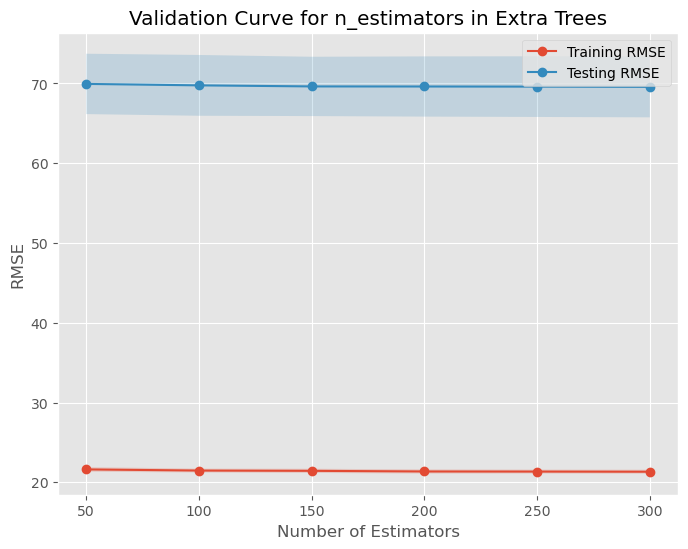

In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve

# Example of how to analyze the sensitivity of 'n_estimators'
param_range = np.arange(50, 301, 50)
train_scores, test_scores = validation_curve(
    best_et, X_train, y_train, param_name="n_estimators", param_range=param_range, cv=10, scoring="neg_mean_squared_error"
)

# Calculate mean and standard deviation of scores
train_rmse = (-train_scores) ** 0.5
test_rmse = (-test_scores) ** 0.5

# Plot the validation curve
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_rmse.mean(axis=1), label="Training RMSE", marker='o')
plt.plot(param_range, test_rmse.mean(axis=1), label="Testing RMSE", marker='o')
plt.fill_between(param_range, train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                 train_rmse.mean(axis=1) + train_rmse.std(axis=1), alpha=0.2)
plt.fill_between(param_range, test_rmse.mean(axis=1) - test_rmse.std(axis=1),
                 test_rmse.mean(axis=1) + test_rmse.std(axis=1), alpha=0.2)
plt.title('Validation Curve for n_estimators in Extra Trees')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.show()

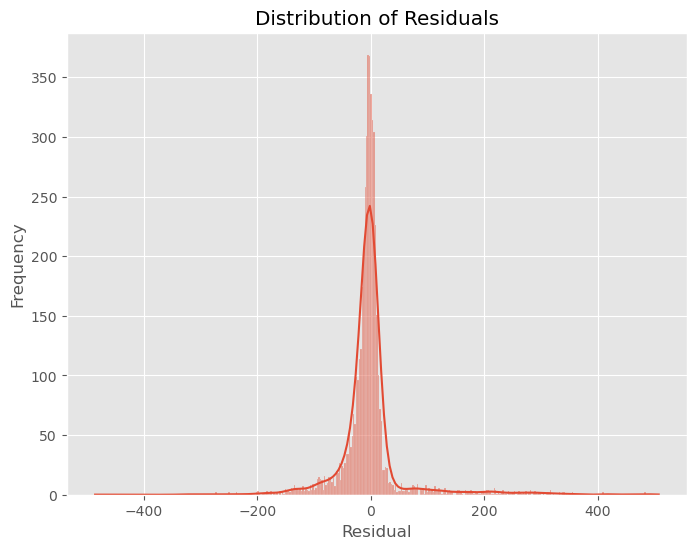

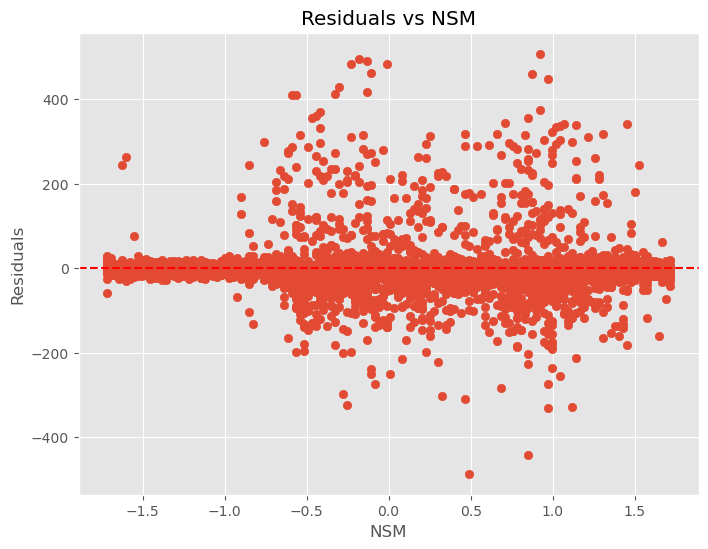

In [ ]:
import numpy as np

# Predict on the test set
y_pred = best_et.predict(X_test)

# Calculate the residuals (errors)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Analyze errors in relation to one of the top features
top_feature = top_features[0]
plt.figure(figsize=(8, 6))
plt.scatter(X_test[top_feature], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals vs {top_feature}')
plt.xlabel(f'{top_feature}')
plt.ylabel('Residuals')
plt.show()